In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import nltk
# from xgboost import XGBClassifier



color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

## Data Exploration

* Fist, let's checkout what files we have.

In [9]:
from subprocess import check_output

print(check_output(["ls", "/Users/wang/work/kaggle/kaggle-cancer-treatment"]).decode("utf8"))

Cancer_Treatment_codes.ipynb
README.md
Redifine_Cancer_Treatment.ipynb
StackNet.jar
data_process.py
generate_stack_submission.py
input
paramssimplev1.txt
paramsv1.txt
querry_pred.csv
stack_pred.csv
stack_pred.numbers
stacknet.model
submission.csv
submission_stacknet.csv
submission_stacknet_submit.csv
submission_xgb.csv
submission_xgb_fold_0.csv
test.sparse
test_stacknet.csv
the1ow1.py
train.sparse
train_stacknet.csv



* There are two kinds of data, now we have a look at there structures.

In [10]:
train_variants_df = pd.read_csv("/Users/wang/Work/kaggle/kaggle-cancer-treatment/input/training_variants")
test_variants_df = pd.read_csv("/Users/wang/Work/kaggle/kaggle-cancer-treatment/input/test_variants")
train_text_df = pd.read_csv("/Users/wang/Work/kaggle/kaggle-cancer-treatment/input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text_df = pd.read_csv("/Users/wang/Work/kaggle/kaggle-cancer-treatment/input/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
print("Train and Test variants shape : ",train_variants_df.shape, test_variants_df.shape)
print("Train and Test text shape : ",train_text_df.shape, test_text_df.shape)

('Train and Test variants shape : ', (3321, 4), (5668, 3))
('Train and Test text shape : ', (3321, 2), (5668, 2))


* What are the top 5 cases in each file.

In [11]:
train_variants_df.head()


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [12]:
train_text_df.head()


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


* Look insight into the lengh of texts

In [13]:
print train_text_df['Text'].apply(lambda x: len(x.split())).describe()


count     3321.000000
mean      9542.415537
std       7845.140815
min          1.000000
25%       4733.000000
50%       6871.000000
75%      11996.000000
max      76708.000000
Name: Text, dtype: float64


In [14]:
print train_variants_df['Gene'].apply(lambda x: len(x)).describe()

count    3321.000000
mean        4.514905
std         0.948606
min         2.000000
25%         4.000000
50%         4.000000
75%         5.000000
max         8.000000
Name: Gene, dtype: float64


* We noticed that the two datasets can be merged by IDs

In [15]:
train_df = pd.merge(train_variants_df, train_text_df, how='left', on='ID').fillna('')
train_df.head()





,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [16]:
test_df = pd.merge(test_variants_df, test_text_df, how='left', on='ID').fillna('')
test_df.head()


,ID,Gene,Variation,Text
0,0,ACSL4,R570S,2. This mutation resulted in a myeloproliferat...
1,1,NAGLU,P521L,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,PAH,L333F,Vascular endothelial growth factor receptor (V...
3,3,ING1,A148D,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,TMEM216,G77A,Abstract Retinoblastoma is a pediatric retina...


## Exploratory Visualization

###  Distribution of classes:

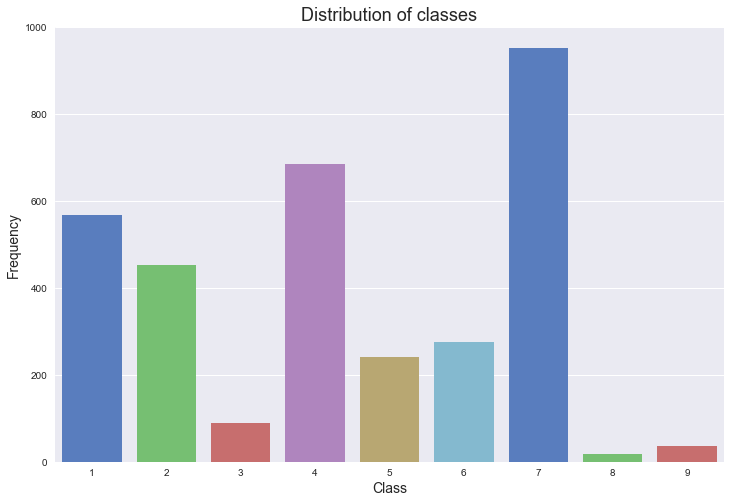

In [17]:
plt.figure(figsize = (12, 8))
sns.countplot(x = "Class", data = train_df, palette = "muted")
plt.ylabel('Frequency', fontsize = 14)
plt.xlabel('Class', fontsize = 14)
plt.title("Distribution of classes", fontsize=18)
plt.show()

The frequency distribution of class is not balance, class 7 has the hightest counts,at around 950, while class 8 and 9 are less than 50.

In [18]:
# # This cell reduces the training data for Kaggle limits. Remove this cell for real results.
train_df, _ = train_test_split(train_df, test_size=0.7, random_state=8, stratify=train_df['Class'])
train_df.shape

(996, 5)

### Distribution of genes

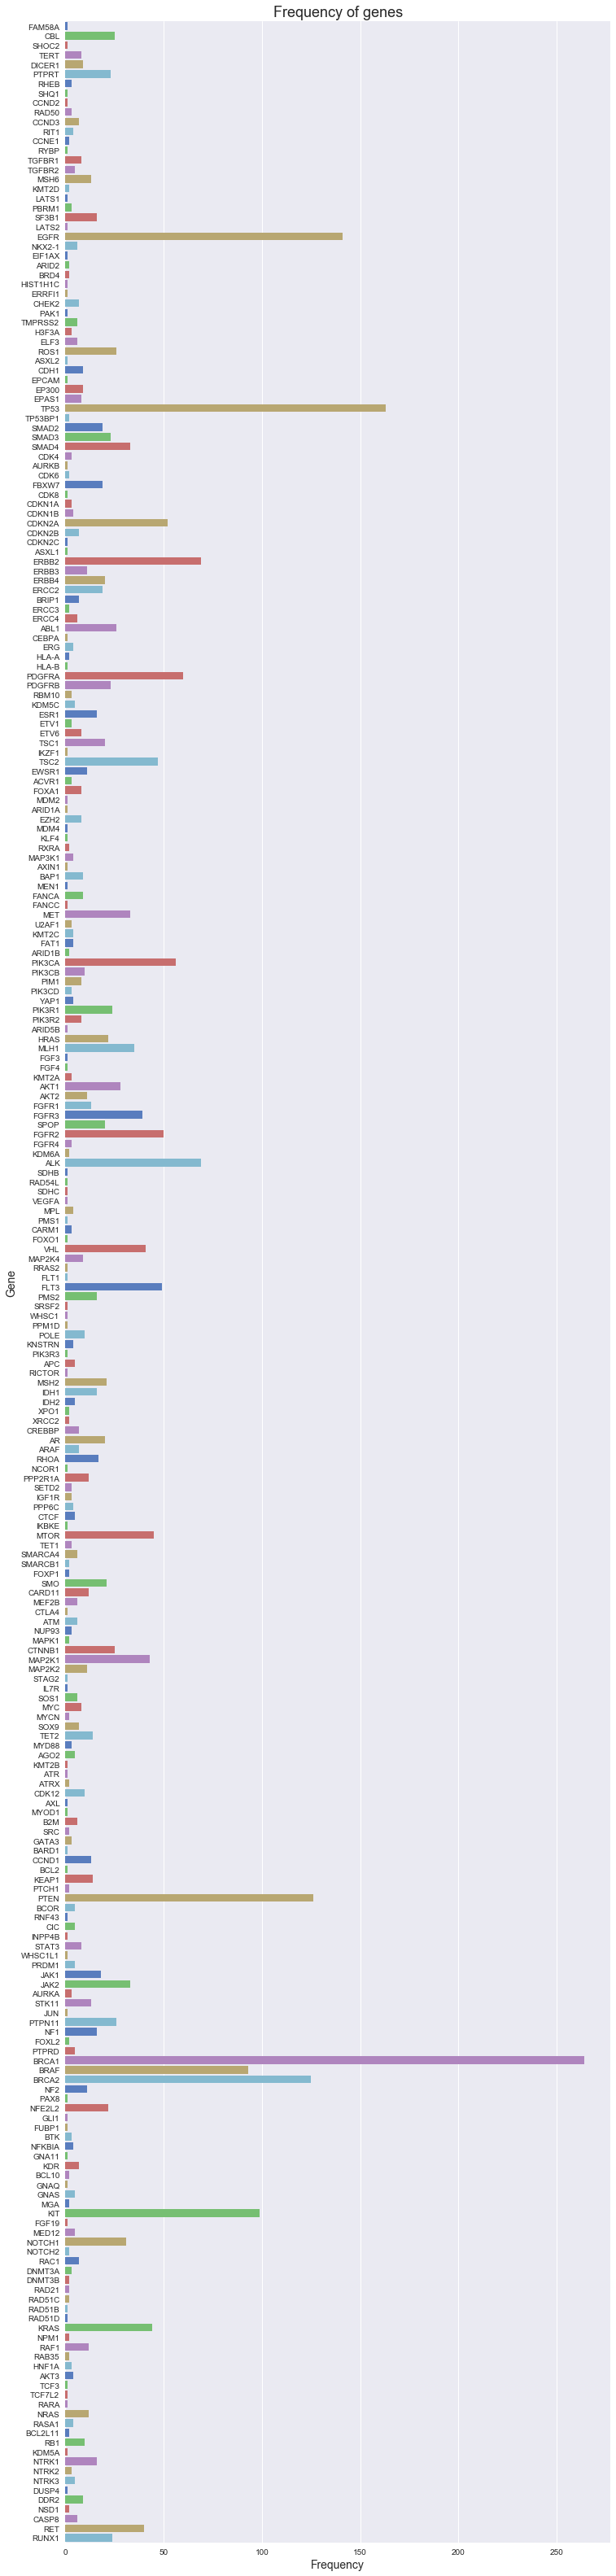

In [19]:
plt.figure(figsize = (12, 57))
sns.countplot(y = "Gene", data = train_variants_df, palette = "muted")
plt.ylabel('Gene', fontsize = 14)
plt.xlabel('Frequency', fontsize = 14)
plt.title("Frequency of genes", fontsize=18)
plt.show()

Genes that appear less than 2 times: 26.89%
Genes that appear less than 5 times: 53.03%
Genes that appear less than 10 times: 71.59%
Genes that appear less than 20 times: 82.95%
Genes that appear less than 50 times: 95.08%
Genes that appear less than 100 times: 98.11%
Genes that appear less than 300 times: 100.0%


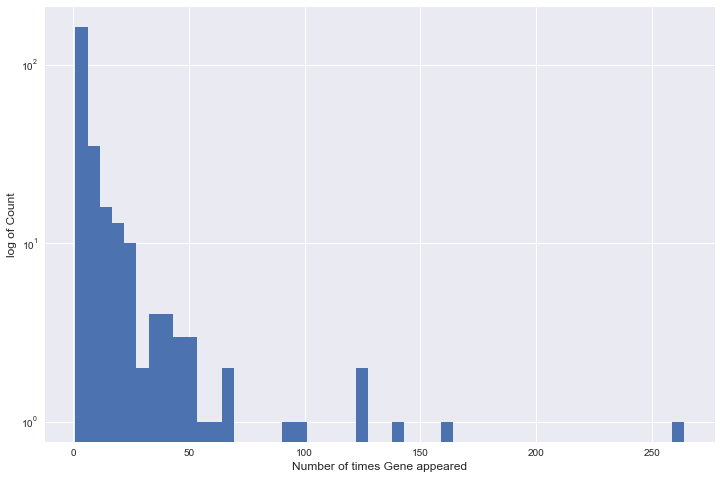

In [25]:
train_genes = train_variants_df.groupby('Gene')['Gene'].count()

for i in [2, 5, 10, 20, 50, 100, 300]:
    print('Genes that appear less than {} times: {}%'.format(i, round((train_genes < i).mean() * 100, 2)))

plt.figure(figsize=(12, 8))
plt.hist(train_genes.values, bins=50, log=True)
plt.xlabel('Number of times Gene appeared', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.show()

### Distribution of variation


In [ ]:
train_variations = train_df.groupby('Variation')['Variation'].count()
# train_variations.describe()
# print train_variations[train_variations > 1]

plt.figure(figsize=(12, 8))
plt.hist(train_variations.values, bins=50, log=True)
plt.xlabel('Number of times variations appeared', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.show()



* Variation data is highly specialized, almost every row has its identical variation label, using it directly as the feature might cause the problem of overfitting.

In [ ]:
# a common evaluator of the feature selection
def evaluate_features(X, y, clf=None):
    """General helper function for evaluating effectiveness of passed features in ML model
    
    Prints out Log loss, accuracy, and confusion matrix with 3-fold stratified cross-validation
    
    Args:
        X (array-like): Features array. Shape (n_samples, n_features)
        
        y (array-like): Labels array. Shape (n_samples,)
        
        clf: Classifier to use. If None, default Log reg is use.
    """
    if clf is None:
        clf = LogisticRegression()
    
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(random_state=8), 
                              n_jobs=-1, method='predict_proba', verbose=2)
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('preds head: {}'.format(preds[:5]))
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))


* Bag of words approach

In [ ]:



count_vectorizer = CountVectorizer(
    analyzer="word",tokenizer=nltk.word_tokenize, 
    preprocessor=None, stop_words='english', max_features=None)    

bag_of_words = count_vectorizer.fit_transform(train_df['Text'])

svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_bag_of_words = svd.fit_transform(bag_of_words)

evaluate_features(truncated_bag_of_words, train_df['Class'].values.ravel())


* TF-IDF approach

In [ ]:
count_vectorizer = TfidfVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=None)    

tfidf = count_vectorizer.fit_transform(train_df['Text'])

# len(count_vectorizer.get_feature_names())

svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf = svd.fit_transform(tfidf)

#evaluate_features(truncated_tfidf, train_df['Class'].values.ravel(),RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))

# tfidf test data

tfidf_test = count_vectorizer.fit_transform(test_df['Text'])

len(count_vectorizer.get_feature_names())

svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
truncated_tfidf_test = svd.fit_transform(tfidf_test)




## Algorithms and Techniques

* merge features

In [ ]:
# one_hot_gene = pd.get_dummies(train_df['Gene'])
# svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
# truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)
# truncated_one_hot_gene.shape


# one_hot_variation = pd.get_dummies(train_df['Variation'])
# svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
# truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)


gene_le = LabelEncoder()
gene_encoded = gene_le.fit_transform(train_df['Gene'].values.ravel()).reshape(-1, 1)
gene_encoded = gene_encoded / np.max(gene_encoded)

variation_le = LabelEncoder()
variation_encoded = variation_le.fit_transform(train_df['Variation'].values.ravel()).reshape(-1, 1)
variation_encoded = variation_encoded / np.max(variation_encoded)


## test

gene_le = LabelEncoder()
gene_encoded_test = gene_le.fit_transform(test_df['Gene'].values.ravel()).reshape(-1, 1)
gene_encoded_test = gene_encoded_test / np.max(gene_encoded_test)

variation_le = LabelEncoder()
variation_encoded_test = variation_le.fit_transform(test_df['Variation'].values.ravel()).reshape(-1, 1)
variation_encoded_test = variation_encoded_test / np.max(variation_encoded_test)




In [ ]:
#merged_train_tfidf = np.hstack((truncated_one_hot_gene, truncated_one_hot_variation, truncated_tfidf))

merged_train_tfidf = np.hstack((gene_encoded, truncated_tfidf))

merged_train_tfidf_test = np.hstack((gene_encoded_test, truncated_tfidf_test))




In [ ]:
#evaluate_features(merged_train_tfidf, train_df['Class'],  RandomForestClassifier(n_estimators=1000, max_depth=5, verbose=1))


In [ ]:
svc_tfidf = SVC(kernel='linear', probability=True)
svc_tfidf.fit(merged_train_tfidf, train_df['Class'])
probas = svc_tfidf.predict(merged_train_tfidf_test)
print probas


In [ ]:
# evaluate_features(merged_train_tfidf, train_df['Class'],    XGBClassifier(max_depth=4,
#                                 objective='multi:softprob',
#                                 learning_rate=0.03333,
#                                 ))

